In [1]:
train_dir = "/kaggle/input/mio-bd/MIO-BD/train"
test_dir = "/kaggle/input/mio-bd/MIO-BD/test"

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications import VGG16,VGG19
from tensorflow.keras.applications import ResNet152V2, DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, InputLayer, BatchNormalization, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
#from keras_self_attention import SeqSelfAttention

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
img_width, img_height = 224, 224
batch_size = 32
epochs = 100
num_classes = 48

In [4]:
train_datagen = ImageDataGenerator( rescale=1./255, rotation_range=30, width_shift_range=0.25, 
                                   height_shift_range=0.25, shear_range=0.25, zoom_range=0.25, 
                                   horizontal_flip=True, fill_mode='nearest' )



test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory( train_dir, 
                                                    target_size=(img_width, img_height), 
                                                    batch_size=batch_size, class_mode='categorical', 
                                                    shuffle=True)

test_generator = test_datagen.flow_from_directory( test_dir, 
                                                  target_size=(img_width, img_height), 
                                                  batch_size=batch_size, class_mode='categorical', 
                                                  shuffle=False )

Found 14103 images belonging to 21 classes.
Found 3474 images belonging to 21 classes.


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, Model

from tensorflow.keras.layers import *

In [6]:
from tensorflow.keras.applications import Xception
base_model = Xception(weights='imagenet', include_top=False, 
                         input_shape=(img_width, img_height, 3))

80134624/80134624 [==============================] - 3s 0us/step


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, Model

In [8]:
from tensorflow.keras.layers import *

In [9]:
x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(21, activation = 'softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)


In [10]:
for layer in model.layers:
    layer.trainable = True

In [11]:
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy', metrics=['accuracy','mse'])

checkpoint = ModelCheckpoint('MobileNetV2+SelfAtten_SplitedDataset.h5',
                             monitor='val_accuracy', save_best_only=True, save_best_weights=True, 
                             mode='max', verbose=2)

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=5, mode='max', verbose=2)

reduce_learning_rate=ReduceLROnPlateau(monitor="val_accuracy",
                                       factor=0.1, patience=5, verbose=2)

In [12]:
history=model.fit(train_generator, epochs=epochs, validation_data=test_generator, 
                  callbacks= [checkpoint, early_stop, reduce_learning_rate])

Epoch 1/100
104/441 [======>.......................] - ETA: 8:43 - loss: 2.6561 - accuracy: 0.1908 - mse: 0.0428

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


441/441 [==============================] - ETA: 0s - loss: 1.8135 - accuracy: 0.4169 - mse: 0.0334
Epoch 1: val_accuracy improved from -inf to 0.57686, saving model to MobileNetV2+SelfAtten_SplitedDataset.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


441/441 [==============================] - 800s 2s/step - loss: 1.8135 - accuracy: 0.4169 - mse: 0.0334 - val_loss: 73.0480 - val_accuracy: 0.5769 - val_mse: 0.0266 - lr: 1.0000e-05
Epoch 2/100
441/441 [==============================] - ETA: 0s - loss: 1.0243 - accuracy: 0.6530 - mse: 0.0221
Epoch 2: val_accuracy improved from 0.57686 to 0.66033, saving model to MobileNetV2+SelfAtten_SplitedDataset.h5
441/441 [==============================] - 563s 1s/step - loss: 1.0243 - accuracy: 0.6530 - mse: 0.0221 - val_loss: 70.5355 - val_accuracy: 0.6603 - val_mse: 0.0222 - lr: 1.0000e-05
Epoch 3/100
441/441 [==============================] - ETA: 0s - loss: 0.8133 - accuracy: 0.7279 - mse: 0.0180
Epoch 3: val_accuracy improved from 0.66033 to 0.69689, saving model to MobileNetV2+SelfAtten_SplitedDataset.h5
441/441 [==============================] - 544s 1s/step - loss: 0.8133 - accuracy: 0.7279 - mse: 0.0180 - val_loss: 77.3722 - val_accuracy: 0.6969 - val_mse: 0.0211 - lr: 1.0000e-05
Epoch 4/

In [13]:
test_result = model.evaluate(test_generator)
#                             steps=test_generator.samples // batch_size)
test_loss = test_result[0]
test_accuracy = test_result[1]
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

109/109 [==============================] - 62s 575ms/step - loss: 75.7594 - accuracy: 0.7709 - mse: 0.0177
Test Loss: 75.75942993164062
Test Accuracy: 0.7708693146705627


In [14]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

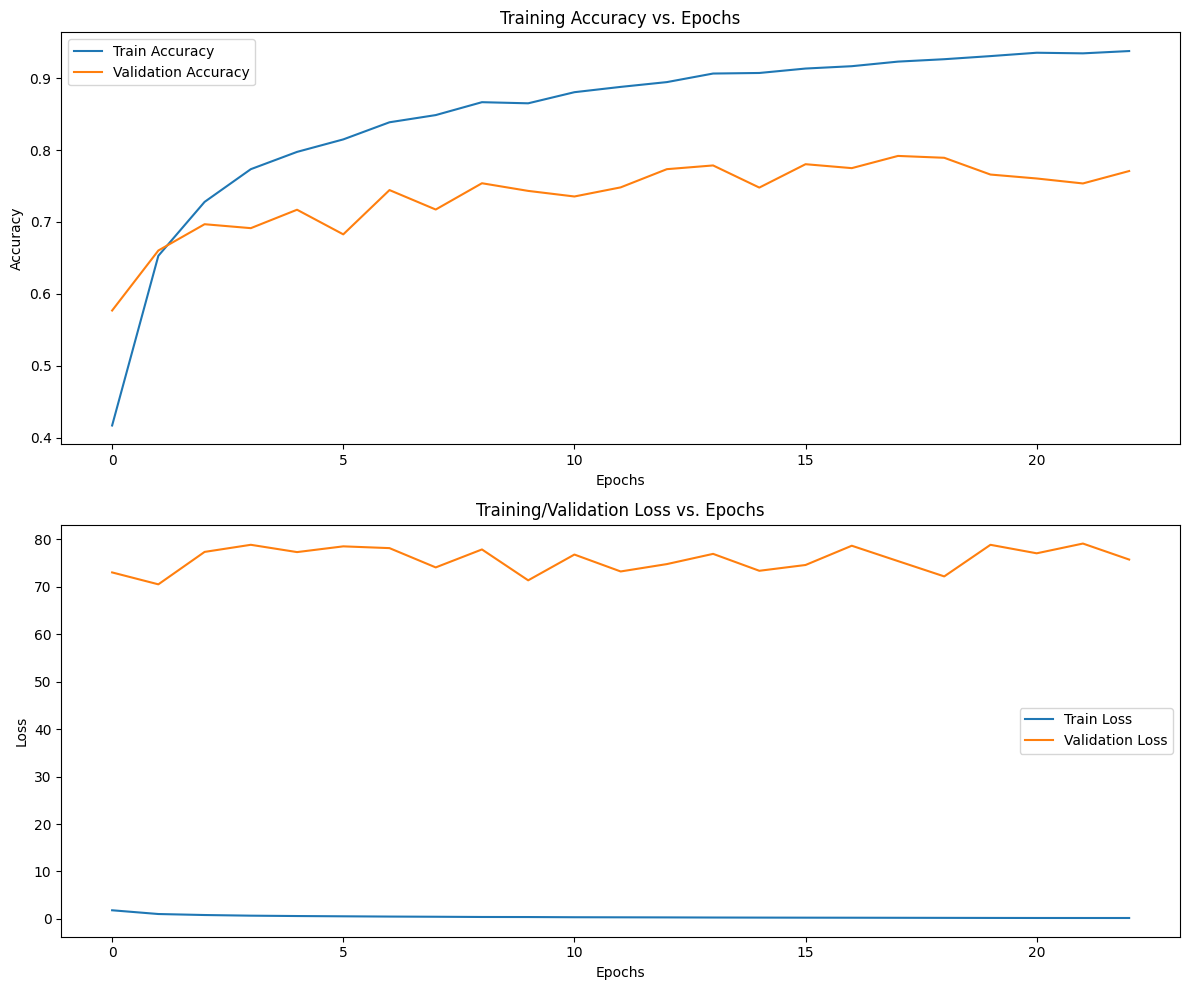

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy,label='Train Accuracy')
ax[0].plot(val_accuracy,label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss,label='Train Loss')
ax[1].plot(val_loss,label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [16]:
train_class_names = sorted(list(train_generator.class_indices.keys()))

test_class_names = sorted(list(test_generator.class_indices.keys()))

assert train_class_names == test_class_names, "Class names in train and test datasets don't match!"

labels = train_class_names

109/109 [==============================] - 69s 632ms/step


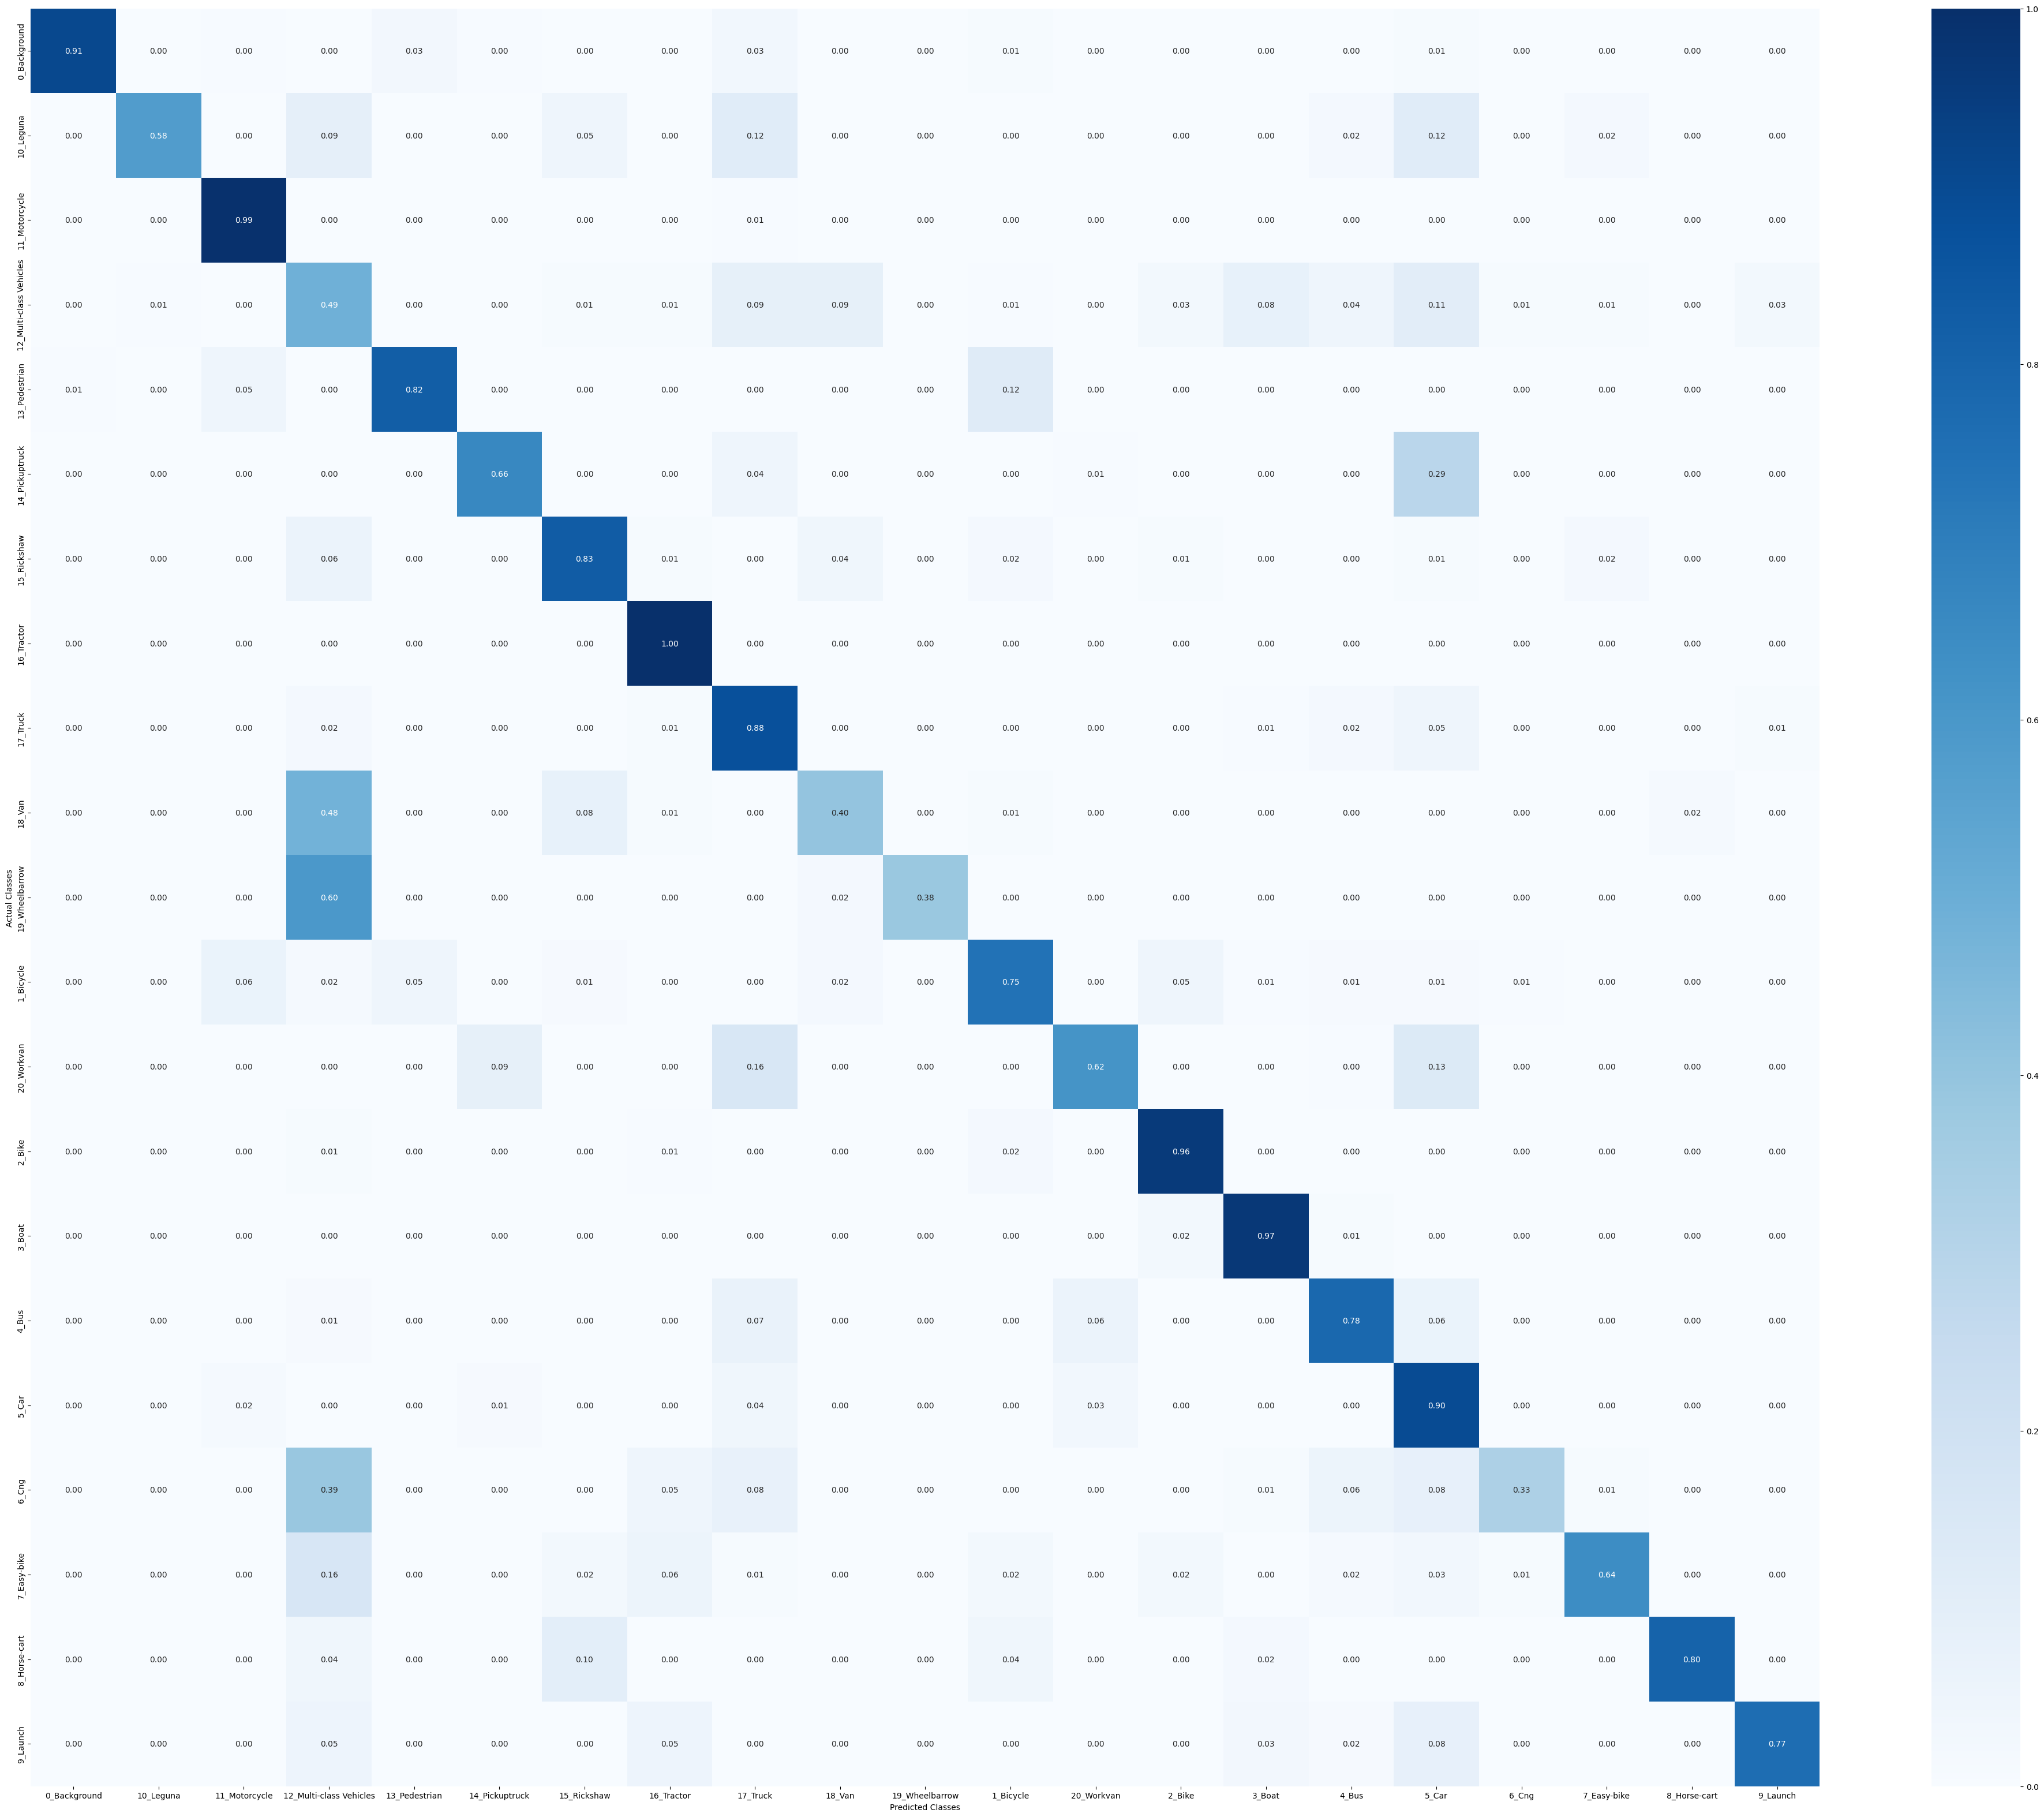

Confusion Matrix:
[[185   0   1   0   6   1   0   0   7   0   0   2   0   0   0   0   2   0
    0   0   0]
 [  0  25   0   4   0   0   2   0   5   0   0   0   0   0   0   1   5   0
    1   0   0]
 [  0   0 161   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  0   1   0  91   0   0   2   2  16  16   0   1   0   5  15   8  20   2
    2   0   5]
 [  1   0   8   0 140   0   0   0   0   0   0  21   0   0   0   0   0   0
    0   0   0]
 [  0   0   0   0   0 106   0   0   7   0   0   0   1   0   0   0  46   0
    0   0   0]
 [  0   0   0   6   0   0  82   1   0   4   0   2   0   1   0   0   1   0
    2   0   0]
 [  0   0   0   0   0   0   0  86   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  0   0   1   7   0   0   0   4 300   0   0   0   0   0   2   8  17   0
    0   0   3]
 [  0   0   0  59   0   0  10   1   0  49   0   1   0   0   0   0   0   0
    0   2   0]
 [  0   0   0  28   0   0   0   0   0   1  18   0   0   0   0   0   0   0
    0   0   0]
 [ 

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have the ground truth labels for the test data in a variable called 'true_labels'
true_labels = test_generator.classes

# Generate predictions for the test data
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Define class labels (replace with your actual class names)
labels = train_class_names  # Replace with your class names

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
fig, ax = plt.subplots(figsize=(50, 40))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap=plt.cm.Blues)
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show()

# Generate the classification report
report = classification_report(true_labels, predicted_labels)

print("Confusion Matrix:")
print(cm)


In [18]:
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       204
           1       0.96      0.58      0.72        43
           2       0.83      0.99      0.90       162
           3       0.33      0.49      0.39       186
           4       0.88      0.82      0.85       170
           5       0.81      0.66      0.73       160
           6       0.76      0.83      0.79        99
           7       0.75      1.00      0.86        86
           8       0.73      0.88      0.79       342
           9       0.64      0.40      0.49       122
          10       1.00      0.38      0.55        47
          11       0.86      0.75      0.80       287
          12       0.82      0.62      0.70       208
          13       0.86      0.96      0.91       172
          14       0.83      0.97      0.89       122
          15       0.86      0.78      0.82       268
          16       0.68      0.90      0.77       384
    

In [19]:
from keras.models import load_model
model.save('VGG19+miobd.h5')

import IPython
IPython.display.FileLink("/kaggle/working/VGG19miobd.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


/kaggle/working/VGG19miobd.h5